In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yt
import yt.units as u
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
'''plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})'''
plt.rcParams.update({
    "text.usetex": True})

In [3]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.interpolate import splev, splrep, interp1d, splint

In [4]:
raw_190, raw114_190, raw_190_peri, raw114_190_peri = np.load(
    'data/m1.0_p10_b1.0_90.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_90.npz'), np.load(
            'data/m1.0_p10_b1.0_peri_90.npz'), np.load(
                'data/m1.0_p10_b1.0_P110_peri_90.npz')

In [5]:
def linear_regression(x, y):
    X = np.array([[(x**2).sum(), (x).sum()],
              [(x).sum(), len(x)]])
    Y = np.array([[(x * y).sum()], [(y).sum()]])
    A, B = np.matmul(np.linalg.inv(X), Y)
    return A, B

In [6]:
def combine(raw, raw_peri):
    x_peri, E_peri = raw_peri['x'], raw_peri['y']
    xmin = np.argmin(x_peri)
    x_peri, E_peri = x_peri[xmin:], E_peri[xmin:]
    x, E = raw['x'], raw['y']
    xmin = np.argmin(x)
    x, E = x[xmin:], E[xmin:]
    E = E[x > x_peri[-1]]
    x = x[x > x_peri[-1]]
    dat = {}
    dat['x'] = np.append(x_peri, x)
    dat['y'] = np.append(E_peri, E)
    return dat

In [89]:
def bin_after(raw, dis, bins=10):
    x = (raw['x'] * u.cm).in_units('Rsun')
    y = np.log10(raw['y'])
    l = len(x[x > dis])
    size = l // bins
    xafter = np.array(
        [x[x > dis][i * size:i * size + bins].mean() for i in range(bins)])
    yafter = np.array(
        [y[x > dis][i * size:i * size + bins].mean() for i in range(bins)])
    xout = np.append(x[x < dis], xafter) * u.Rsun / u.cm
    return {'x': xout.in_cgs(), 'y': 10**np.append(y[x < dis], yafter)}

In [7]:
def smooth_evol(raw, ax, label, lens=65, lower=-1, s=1e-4, rp=1):
    x = (raw['x'][lower:] * u.cm).in_units('Rsun').v
    y = np.log10(raw['y'][lower:])
    spl = splrep(x, y, s=s, k=5)
    x1 = np.logspace(np.log10(x[0]), np.log10(x[-1]), 100)
    y1 = 10**splev(x1, spl)
    ax.plot(x1 / rp, y1, label=label)
    return spl, x[0], x[-1]


def smooth_evol_bin(raw, lower=4, bins=5):
    x = np.log10((raw['x'][lower:] * u.cm).in_units('Rsun').v)
    y = np.log10(raw['y'][lower:])
    X = np.array([x[i:i + bins].mean() for i in range(len(x) - bins)])
    Y = np.array([y[i:i + bins].mean() for i in range(len(x) - bins)])
    return 10**X, 10**Y

In [8]:
def plot_ed(raw, raw114, rawe, bins=10):
    r = np.array([3, 4])

    f, ax = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

    ax[0].plot((raw['x'][4:] * u.cm).in_units('Rsun'), raw['y'][4:])
    s = smooth_evol_bin(raw, bins=bins)
    ax[1].plot(s[0], s[1], color='k')

    ax[0].plot((raw114['x'][4:] * u.cm).in_units('Rsun'), raw114['y'][4:])
    s_114 = smooth_evol_bin(raw114, bins=bins)
    ax[1].plot(s_114[0], s_114[1], color='grey')

    ax[0].plot((rawe['x'][8:] * u.cm).in_units('Rsun'), rawe['y'][8:])
    s_e = smooth_evol_bin(rawe, bins=bins, lower=8)
    ax[1].plot(s_e[0], s_e[1], color='grey', linestyle='--')

    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[1].set_yscale('log')
    #ax[0].set_xlim(1e3, 4e3)
    f.tight_layout()
    plt.show()

## Cut by Unbound Mass

In [10]:
ubd_190, ubd114_190, ubde_190 = np.load(
    'data/m1.0_p10_b1.0_90_ubd.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_90_ubd.npz'), np.load(
            'data/m1.0_p10_b1.0_e9_90_ubd.npz')
ubd_150, ubd114_150, ubde_150 = np.load(
    'data/m1.0_p10_b1.0_50_ubd.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_50_ubd.npz'), np.load(
            'data/m1.0_p10_b1.0_e9_50_ubd.npz')

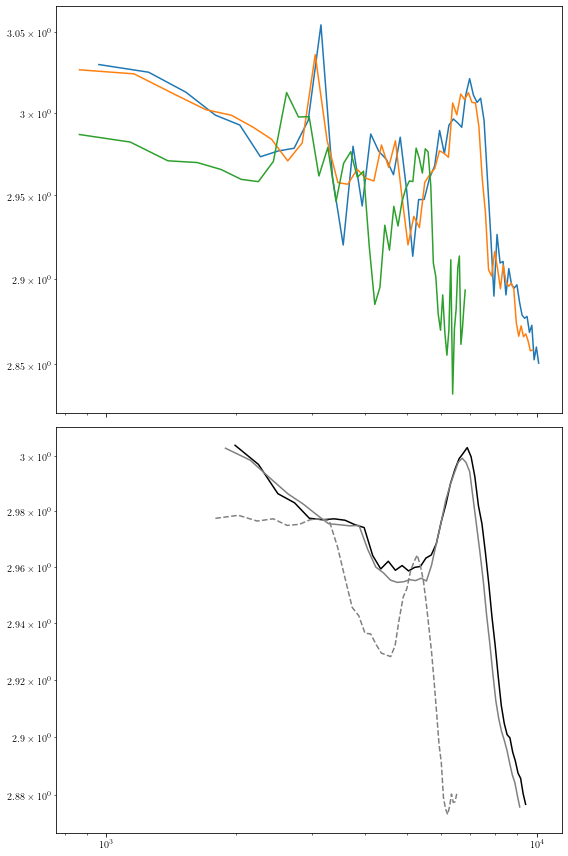

In [11]:
plot_ed(ubd_190, ubd114_190, ubde_190)

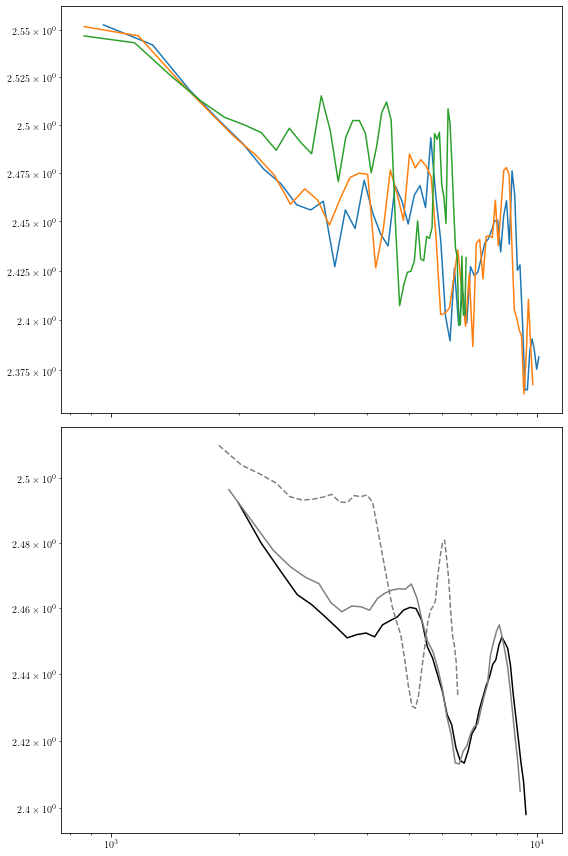

In [12]:
plot_ed(ubd_150, ubd114_150, ubde_150)

## Cut by Energy

In [13]:
de_198, de114_198, dee_198 = np.load(
    'data/m1.0_p10_b1.0_98_de.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_98_de.npz'), np.load(
            'data/m1.0_p10_b1.0_e9_98_de.npz')
de_190, de114_190, dee_190 = np.load(
    'data/m1.0_p10_b1.0_90_de.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_90_de.npz'), np.load(
            'data/m1.0_p10_b1.0_e9_90_de.npz')
de_150, de114_150, dee_150 = np.load(
    'data/m1.0_p10_b1.0_50_de.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_50_de.npz'), np.load(
            'data/m1.0_p10_b1.0_e9_50_de.npz')

In [14]:
de_0898, de114_0898, dee_0898 = np.load(
    'data/m1.0_p10_b0.8_98_de.npz'), np.load(
        'data/m1.0_p10_b0.8_P110_98_de.npz'), np.load(
            'data/m1.0_p10_b0.8_e9_98_de.npz')

In [15]:
de_198_peri, de114_198_peri, dee_198_peri = np.load(
    'data/m1.0_p10_b1.0_peri_98_de_peri.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_peri_98_de_peri.npz'), np.load(
            'data/m1.0_p10_b1.0_e9_peri_98_de_peri.npz')

de_190_peri, de114_190_peri, dee_190_peri = np.load(
    'data/m1.0_p10_b1.0_peri_90_de_peri.npz'), np.load(
        'data/m1.0_p10_b1.0_P110_peri_90_de_peri.npz'), np.load(
            'data/m1.0_p10_b1.0_e9_peri_90_de_peri.npz')

de_0898_peri, de114_0898_peri, dee_0898_peri = np.load(
    'data/m1.0_p10_b0.8_peri_98_de_peri.npz'), np.load(
        'data/m1.0_p10_b0.8_P110_peri_98_de_peri.npz'), np.load(
            'data/m1.0_p10_b0.8_e9_peri_98_de_peri.npz')

In [16]:
de_198 = combine(de_198, de_198_peri)
de114_198 = combine(de114_198, de114_198_peri)
dee_198 = combine(dee_198, dee_198_peri)

de_190 = combine(de_190, de_190_peri)
de114_190 = combine(de114_190, de114_190_peri)
dee_190 = combine(dee_190, dee_190_peri)

In [17]:
de_0898 = combine(de_0898, de_0898_peri)
de114_0898 = combine(de114_0898, de114_0898_peri)
dee_0898 = combine(dee_0898, dee_0898_peri)

In [18]:
rp1 = (raw_190_peri['x'] * u.cm).in_units('Rsun').min()

In [111]:
def plot_de(raw, raw114, rawe, rp1, lower=[0, 0, 0]):
    f, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
    bin114 = bin_after(raw114, dis=6*rp1, bins=10)
    ax[0].scatter((raw114['x'] / rp1).in_cgs(), raw114['y'])
    spl2, xmin1, xmax1 = smooth_evol(bin114,
                                     ax[0],
                                     '$P = 114\ \mathrm{d}$',
                                     lens=60,
                                     lower=lower[1],
                                     s=1e-4,
                                     rp=rp1)
    
    bine = bin_after(rawe, dis=7*rp1, bins=10)
    ax[0].scatter((rawe['x'] / rp1).in_cgs(), rawe['y'])  
    spl3, xmin2, xmax2 = smooth_evol(bine,
                                     ax[0],
                                     '$e = 0.9$',
                                     lens=60,
                                     lower=lower[2],
                                     s=2e-5,
                                     rp=rp1)

    
    bin = bin_after(raw, dis=6*rp1, bins=10)
    ax[0].scatter((raw['x'] / rp1).in_cgs(), raw['y'])
    spl1, xmin, xmax = smooth_evol(bin,
                                   ax[0],
                                   '$\mathrm{Parabolic}$',
                                   lens=60,
                                   lower=lower[0],
                                   s=1e-4,
                                   rp=rp1)
    r = np.array([1, 2]) * rp1
    ax[1].plot(r / rp1, [0, 1 - 10**(splev(r[1], spl1) - splev(r[1], spl2))],
               linestyle='--')
    ax[1].plot(r / rp1, [0, 1 - 10**(splev(r[1], spl1) - splev(r[1], spl3))],
               linestyle='--')

    r1 = np.logspace(np.log10(2 * rp1), np.log10(xmax1 / 1.1), 50)
    ax[1].scatter(r1 / rp1, 1 - 10**(splev(r1, spl1) - splev(r1, spl2)))
    r2 = np.logspace(np.log10(2 * rp1), np.log10(xmax2 / 1.1), 50)
    ax[1].scatter(r2 / rp1, 1 - 10**(splev(r2, spl1) - splev(r2, spl3)))

    #ax[0].set_xlim(10, 25)
    #ax[0].set_ylim(1.95, 2.05)
    ax[0].set_xscale('log')
    #ax[1].set_ylim(0, 0.01)
    #ax[1].set_yscale('log')

    ax[0].set_xlabel(r'$r/r_\mathrm{p}$', fontsize=25)
    ax[0].set_ylabel(r'$\Delta E/\delta E$', fontsize=25)
    ax[1].set_xlabel(r'$r/r_\mathrm{p}$', fontsize=25)
    ax[1].set_ylabel(r'$\mathrm{Deviation}$', fontsize=25)
    ax[0].tick_params(labelsize=20)
    ax[1].tick_params(labelsize=20)
    ax[0].legend()
    f.tight_layout()
    return f

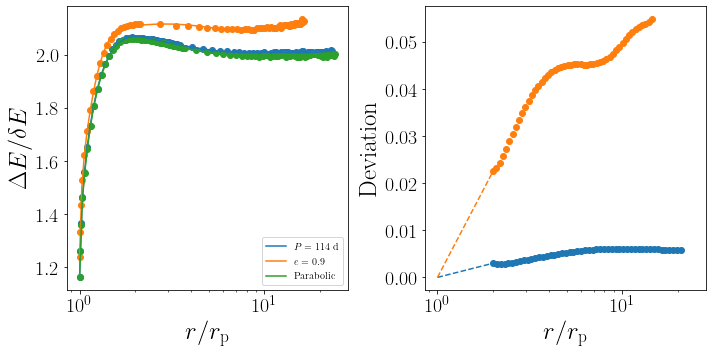

In [112]:
f = plot_de(de_198, de114_198, dee_198, rp1=rp1);
#f.savefig('DeltaE_radius.pdf', b)
#plot_de(de_190, de114_190, dee_190, rp1=rp1)

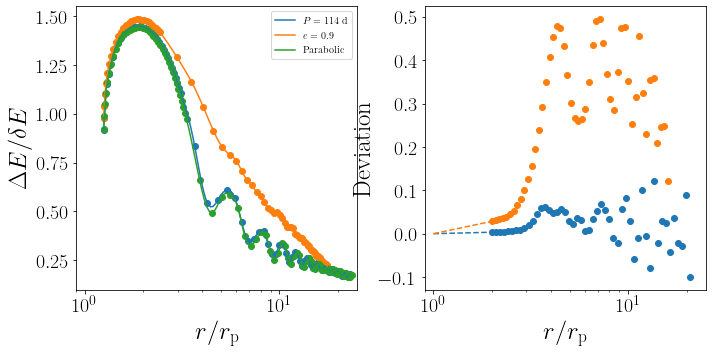

In [30]:
plot_de(de_0898, de114_0898, dee_0898, rp1=rp1);

## Cut By Total Mass

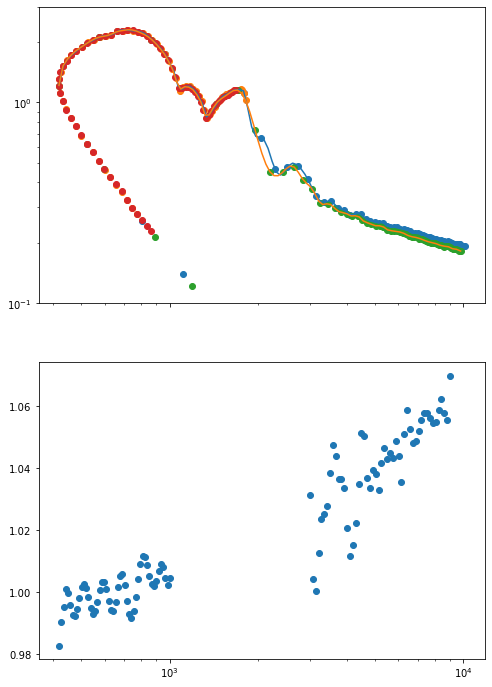

(1.0, 1.1)

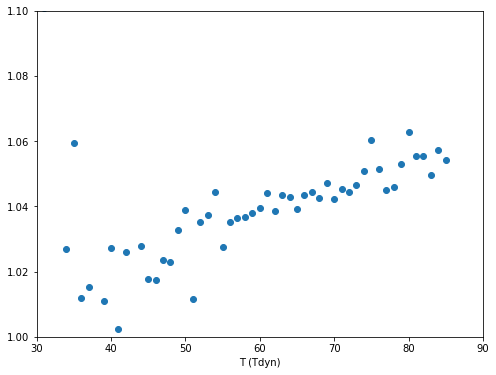

In [174]:
f, ax = plt.subplots(2, 1, figsize=(8, 12), sharex=True)
ax[0].scatter((raw_190['x'] * u.cm).in_units('Rsun'), raw_190['y'])
ax[0].scatter((raw_190_peri['x'] * u.cm).in_units('Rsun'), raw_190_peri['y'])
spl1, xmin = smooth_evol(combine(raw_190, raw_190_peri), ax[0], 'None', lens=60)
ax[0].scatter((raw114_190['x'] * u.cm).in_units('Rsun'), raw114_190['y'])
ax[0].scatter((raw114_190_peri['x'] * u.cm).in_units('Rsun'), raw114_190_peri['y'])
spl2, xmin = smooth_evol(combine(raw114_190, raw114_190_peri), ax[0], 'None', lens=60)
#plt.xlim(300, 1e4)
r = np.append(np.logspace(np.log10(xmin), 3, 50),
              np.logspace(np.log10(3000), np.log10(9000), 50))
ax[1].scatter(r, 10**(splev(r, spl1) - splev(r, spl2)))
ax[0].set_ylim(1e-1, 3)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(raw_190['x']))+20,
            (raw_190['y'] / raw114_190['y']))
plt.xlabel('T (Tdyn)')
plt.xlim(30, 90)
plt.ylim(1, 1.1)

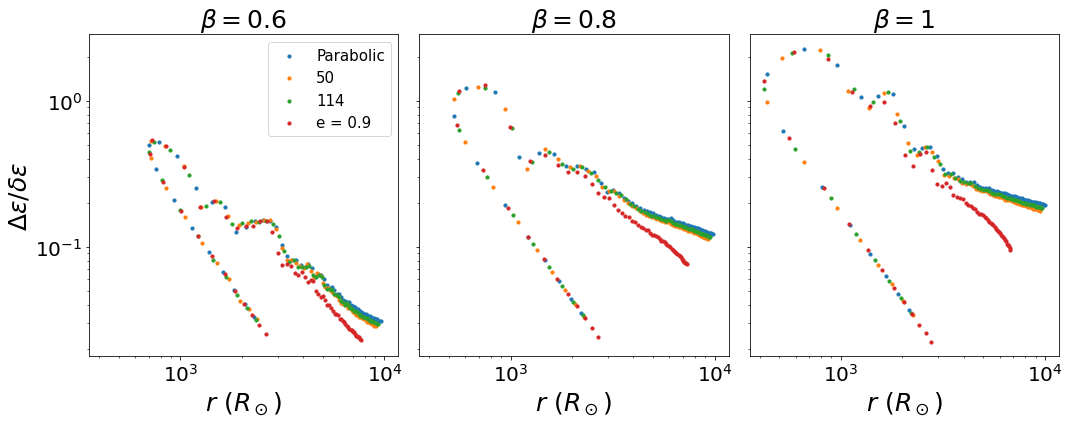

In [21]:
lens = 65
f, ax = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
'''smooth_evol(raw_0690, ax[0], 'Parabolic')
smooth_evol(raw50_0690, ax[0], '50')
smooth_evol(raw114_0690, ax[0], '114')
smooth_evol(rawe_0690, ax[0], 'low e')
smooth_evol(raw_0890, ax[1], 'Parabolic')
smooth_evol(raw50_0890, ax[1], '50')
smooth_evol(raw114_0890, ax[1], '114')
smooth_evol(raw_190, ax[2], 'Parabolic')
smooth_evol(raw50_190, ax[2], '50')
smooth_evol(raw114_190, ax[2], '114')
smooth_evol(rawe_190, ax[2], 'low e')'''
parabolic = [raw_0690, raw_0890, raw_190]
eccl = [raw50_0690, raw50_0890, raw50_190]
ecch = [raw114_0690, raw114_0890, raw114_190]
ecc = [rawe_0690, rawe_0890, rawe_190]
titles = [r'$\beta=0.6$', r'$\beta=0.8$', r'$\beta=1$']
for i in range(3):
    ax[i].scatter((parabolic[i]['x'][:lens] * u.cm).in_units('Rsun'),
                  parabolic[i]['y'][:lens],
                  label='Parabolic',
                  s=10)
    ax[i].scatter((eccl[i]['x'][:lens] * u.cm).in_units('Rsun'),
                  eccl[i]['y'][:lens],
                  label='50',
                  s=10)
    ax[i].scatter((ecch[i]['x'][:lens] * u.cm).in_units('Rsun'),
                  ecch[i]['y'][:lens],
                  label='114',
                  s=10)
    ax[i].scatter((ecc[i]['x'][:lens] * u.cm).in_units('Rsun'),
                  ecc[i]['y'][:lens],
                  label='e = 0.9',
                  s=10)
    ax[i].set_title(titles[i], fontsize=25)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].tick_params(labelsize=20)
    ax[i].set_xlabel(r'$r\ (R_\odot)$', fontsize=25)
ax[0].set_ylabel(r'$\Delta \epsilon/\delta \epsilon$', fontsize=25)
#ax[0].set_ylim(2e-2, 3)
ax[0].legend(fontsize=15)
f.tight_layout()
f.savefig('/Users/chang/Desktop/Energy_Dispersion.png')